In [1]:
# === Generate (s,a,r,s') tuple from real trips ===

import pandas as pd
import numpy as np

# === Step 1: Load Parquet taxi trip data ===
df = pd.read_parquet('./cleaned_data/cleaned_yellow_tripdata_2024-01.parquet')

# === Step 2: Preprocess: Add time bins ===
def get_time_bin_fifteen_minutes(timestamp):
    return timestamp.hour * 4 + timestamp.minute // 15  # 15 min bin

# Convert Pickup and Dropoff Datetime to time bins
df['pickup_time_bin'] = pd.to_datetime(df['PickupDatetime']).apply(get_time_bin_fifteen_minutes)
df['dropoff_time_bin'] = pd.to_datetime(df['DropoffDatetime']).apply(get_time_bin_fifteen_minutes)

# === Step 3: Build (s, a, r, s') Samples ===
samples = []

# Group by (pickup_zone, pickup_time_bin)
grouped = df.groupby(['PULocationID', 'pickup_time_bin'])

num_time_bins = 96

for (s_zone, t_bin), group in grouped:
    for _, trip in group.iterrows():
        try:
            # Current state (s_zone, t_bin)
            s = (s_zone, t_bin)

            # Action: pick this trip → dropoff zone
            a_zone = int(trip['DOLocationID'])
            fare = float(trip['FareAmount'])

            # Next state (dropoff zone, dropoff time bin)
            s_prime_zone = a_zone
            s_prime_t_bin = int(trip['dropoff_time_bin']) % num_time_bins

            # Save this (s, a, r, s') sample
            samples.append({
                's_zone': s_zone,
                't_bin': t_bin,
                'a_zone': a_zone,
                'reward': fare,
                's_prime_zone': s_prime_zone,
                's_prime_t_bin': s_prime_t_bin
            })

        except Exception as e:
            continue  # Ignore invalid rows
            
    try:
        samples.append({
            's_zone': s_zone,
            't_bin': t_bin,
            'a_zone': s_zone,  # stay
            'reward': -1.0,    # small negative reward for wasting time
            's_prime_zone': s_zone,
            's_prime_t_bin': (t_bin + 1) % num_time_bins
        })
    except Exception as e:
        continue

# === Step 4: Save to CSV ===
samples_df = pd.DataFrame(samples)
samples_df.to_csv('./data_for_q_learning/q_learning_samples_realistic_2024-01.csv', index=False)

print(f"✅ Done! Generated {len(samples_df)} (s, a, r, s') samples and saved to './data_for_q_learning/q_learning_samples_realistic_2024-01.csv'")


✅ Done! Generated 2681285 (s, a, r, s') samples and saved to './data_for_q_learning/q_learning_samples_realistic_2024-01.csv'


In [2]:
import pandas as pd
df = pd.read_csv("./data_for_q_learning/q_learning_samples_realistic_2024-01.csv")
df

,s_zone,t_bin,a_zone,reward,s_prime_zone,s_prime_t_bin
0,1,21,265,35.9,265,22
1,1,21,1,-1.0,1,22
2,1,24,1,70.0,1,26
3,1,24,1,-1.0,1,25
4,1,59,265,35.9,265,60
...,...,...,...,...,...,...
2681280,265,94,265,-1.0,265,95
2681281,265,95,265,10.0,265,95
2681282,265,95,265,60.0,265,95
2681283,265,95,68,38.7,68,1


In [6]:
# === Training Q-learning ===
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import os

# === Step 1: Load the new (s, a, r, s') samples ===
num_time_bins = 96  # 15min
samples_path = './data_for_q_learning/q_learning_samples_realistic_2024-01.csv'
df = pd.read_csv(samples_path)

# Encode all zone IDs into continuous integer IDs
all_zone_ids = pd.unique(df[['s_zone', 'a_zone', 's_prime_zone']].values.ravel())
zone_id_map = {z: i for i, z in enumerate(sorted(all_zone_ids))}
num_zones = len(zone_id_map)

# Map original zone IDs to 0,1,2,3,... for embedding
df['s_zone'] = df['s_zone'].map(zone_id_map)
df['a_zone'] = df['a_zone'].map(zone_id_map)
df['s_prime_zone'] = df['s_prime_zone'].map(zone_id_map)

# === Step 2: Define PyTorch Dataset ===
class QLearningDataset(Dataset):
    def __init__(self, df):
        self.s_zone = torch.tensor(df['s_zone'].values, dtype=torch.long)
        self.t_bin = torch.tensor(df['t_bin'].values, dtype=torch.long)
        self.a_zone = torch.tensor(df['a_zone'].values, dtype=torch.long)
        self.reward = torch.tensor(df['reward'].values, dtype=torch.float32)
        self.s_prime_zone = torch.tensor(df['s_prime_zone'].values, dtype=torch.long)
        self.s_prime_t_bin = torch.tensor(df['s_prime_t_bin'].values, dtype=torch.long)

    def __len__(self):
        return len(self.s_zone)

    def __getitem__(self, idx):
        return (self.s_zone[idx], self.t_bin[idx], self.a_zone[idx],
                self.reward[idx], self.s_prime_zone[idx], self.s_prime_t_bin[idx])

dataset = QLearningDataset(df)
# dataloader = DataLoader(dataset, batch_size=4096, shuffle=True, num_workers=4)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True, num_workers=0)


# === Step 3: Define Q-network ===
class QNetwork(nn.Module):
    def __init__(self, num_zones, num_time_bins, embed_dim=16):
        super().__init__()
        self.zone_embed = nn.Embedding(num_zones, embed_dim)
        self.time_embed = nn.Embedding(num_time_bins, embed_dim)
        self.net = nn.Sequential(
            nn.Linear(embed_dim * 3, 128),  # 适度扩大 hidden layer
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, s_zone, t_bin, a_zone):
        s_embed = self.zone_embed(s_zone)
        t_embed = self.time_embed(t_bin)
        a_embed = self.zone_embed(a_zone)
        x = torch.cat([s_embed, t_embed, a_embed], dim=1)
        return self.net(x).squeeze(1)

# Instantiate models
q_net = QNetwork(num_zones, num_time_bins)
target_q_net = QNetwork(num_zones, num_time_bins)
target_q_net.load_state_dict(q_net.state_dict())  # Copy initial weights

# === Step 4: Setup training components ===
optimizer = optim.Adam(q_net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
gamma = 0.99

# === Step 5: Training loop ===
epochs = 20
epoch_losses = []
tau = 0.005  # Soft update coefficient

os.makedirs("./Q_learning", exist_ok=True)

for epoch in range(epochs):
    q_net.train()
    total_loss = 0
    tqdm_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")

    for s, t, a, r, s_p, t_p in tqdm_bar:
        with torch.no_grad():
            a_prime = torch.arange(num_zones).repeat(len(s_p), 1).to(torch.long)
            s_prime_rep = s_p.unsqueeze(1).repeat(1, num_zones).flatten()
            t_prime_rep = t_p.unsqueeze(1).repeat(1, num_zones).flatten()
            a_prime_flat = a_prime.flatten()

            q_values = target_q_net(s_prime_rep, t_prime_rep, a_prime_flat)
            q_values = q_values.view(len(s_p), num_zones)
            max_q = q_values.max(dim=1)[0]

        target = r + gamma * max_q
        pred_q = q_net(s, t, a)
        loss = loss_fn(pred_q, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        tqdm_bar.set_postfix(batch_loss=loss.item())

        # === Soft update target network ===
        with torch.no_grad():
            for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
                target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    epoch_losses.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# === Step 6: Save model and loss ===
torch.save(q_net.state_dict(), f"./Q_learning/q_network_realistic_{epochs}_epochs.pt")
pd.DataFrame({'epoch': list(range(1, len(epoch_losses)+1)), 'loss': epoch_losses})\
  .to_csv(f"./Q_learning/q_training_loss_realistic_{epochs}_epochs.csv", index=False)

print(f"✅ Training finished. Model and loss history saved.")


Epoch 1: 100%|██████████| 655/655 [07:13<00:00,  1.51it/s, batch_loss=83.7]


Epoch 1, Loss: 95589.0429


Epoch 2: 100%|██████████| 655/655 [07:12<00:00,  1.51it/s, batch_loss=72.5]


Epoch 2, Loss: 49813.2337


Epoch 3: 100%|██████████| 655/655 [07:09<00:00,  1.53it/s, batch_loss=55.4]


Epoch 3, Loss: 41979.9844


Epoch 4: 100%|██████████| 655/655 [09:26<00:00,  1.16it/s, batch_loss=52.6]


Epoch 4, Loss: 35710.7257


Epoch 5: 100%|██████████| 655/655 [12:33<00:00,  1.15s/it, batch_loss=46.9]


Epoch 5, Loss: 31450.2858


Epoch 6: 100%|██████████| 655/655 [12:41<00:00,  1.16s/it, batch_loss=46]  


Epoch 6, Loss: 28771.6464


Epoch 7: 100%|██████████| 655/655 [08:16<00:00,  1.32it/s, batch_loss=37.6]


Epoch 7, Loss: 26607.2546


Epoch 8: 100%|██████████| 655/655 [06:41<00:00,  1.63it/s, batch_loss=39.3]


Epoch 8, Loss: 24961.0051


Epoch 9: 100%|██████████| 655/655 [06:46<00:00,  1.61it/s, batch_loss=39.6]


Epoch 9, Loss: 23849.0852


Epoch 10: 100%|██████████| 655/655 [07:56<00:00,  1.37it/s, batch_loss=30.7]


Epoch 10, Loss: 23036.5423


Epoch 11: 100%|██████████| 655/655 [08:45<00:00,  1.25it/s, batch_loss=33.8]


Epoch 11, Loss: 22165.0976


Epoch 12: 100%|██████████| 655/655 [08:45<00:00,  1.25it/s, batch_loss=36.7]


Epoch 12, Loss: 21663.6941


Epoch 13: 100%|██████████| 655/655 [07:00<00:00,  1.56it/s, batch_loss=34.2]


Epoch 13, Loss: 21142.6696


Epoch 14: 100%|██████████| 655/655 [06:52<00:00,  1.59it/s, batch_loss=28.4]


Epoch 14, Loss: 20871.1706


Epoch 15: 100%|██████████| 655/655 [06:51<00:00,  1.59it/s, batch_loss=30.8]


Epoch 15, Loss: 20610.0068


Epoch 16: 100%|██████████| 655/655 [06:48<00:00,  1.61it/s, batch_loss=28.3]


Epoch 16, Loss: 20362.0797


Epoch 17: 100%|██████████| 655/655 [07:12<00:00,  1.51it/s, batch_loss=36.6]


Epoch 17, Loss: 20232.3057


Epoch 18: 100%|██████████| 655/655 [07:12<00:00,  1.51it/s, batch_loss=25]  


Epoch 18, Loss: 20150.9315


Epoch 19: 100%|██████████| 655/655 [07:21<00:00,  1.48it/s, batch_loss=29]  


Epoch 19, Loss: 19943.0643


Epoch 20: 100%|██████████| 655/655 [07:05<00:00,  1.54it/s, batch_loss=25.7]

Epoch 20, Loss: 19863.5511
✅ Training finished. Model and loss history saved.


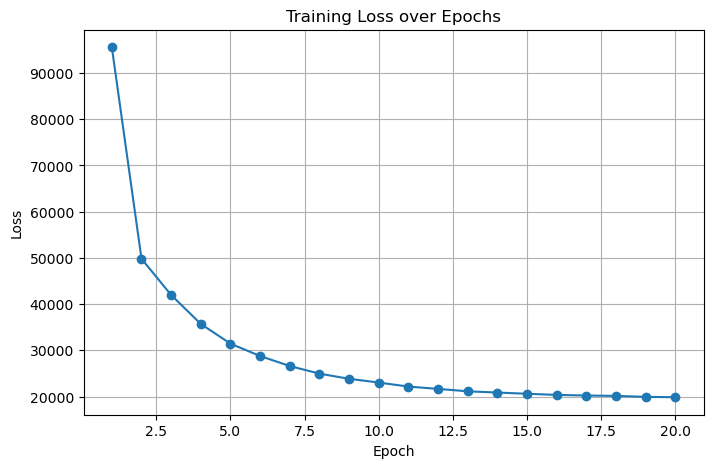

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./Q_learning/q_training_loss_realistic_20_epochs.csv")

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(df['epoch'], df['loss'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()